# This Example shows how to Semantically Segment CloudNet38 satellite images using the deep learning model Fully Convolutional Network.

### Import Modules

In [32]:
import sys
import os
import numpy as np
import time
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from geotorchai.models.raster import FullyConvolutionalNetwork
from geotorchai.datasets.raster import Cloud38
from geotorchai.utility import TorchAdapter
import matplotlib.pyplot as plt

# Import Apache Sedona
from sedona.spark import *

## Import PySpark
from pyspark.sql import SparkSession


## Import distributed modules
from torch.utils.data import DistributedSampler, DataLoader
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from pyspark.ml.torch.distributor import TorchDistributor

In [ ]:
config = SedonaContext.builder().master(MASTER_URL).config('spark.jars.packages',
           'org.apache.sedona:sedona-spark-shaded-3.0_2.12:1.4.1,'
           'org.datasyslab:geotools-wrapper:1.4.0-28.2').getOrCreate()

spark = SedonaContext.create(config)
sc = spark.sparkContext

## Get Path Prefix

In [33]:
from pathlib import Path

PATH_PREFIX= str(Path.home()) + '/' if os.environ.get('ENV_WB', 'false') == 'true' else '/'

print(PATH_PREFIX)

/


In [3]:
## Define parameters
learning_rate = 0.0002
batch_size = 8

## make sure that PATH_TO_DATASET exists in the running directory
dataset_path = PATH_PREFIX + "data/38-Cloud_training"

### Load Data and Add Normalization Transformation

In [5]:
## load data and calculate mean and std to perform normalization transform
full_data = Cloud38(root = dataset_path)

full_loader = DataLoader(full_data, batch_size= batch_size)
channels_sum, channels_squared_sum, num_batches = 0, 0, 0
for i, sample in enumerate(full_loader):
    data_temp, _ = sample
    channels_sum += torch.mean(data_temp, dim=[0, 2, 3])
    channels_squared_sum += torch.mean(data_temp**2, dim=[0, 2, 3])
    num_batches += 1

mean = channels_sum / num_batches
std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

In [6]:
## Define the transform operation
sat_transform = transforms.Normalize(mean, std)
## Load data with desired transformation and additional handcrafted features enabled
full_data = Cloud38(root = dataset_path, transform = sat_transform)

### Display Spectral Bands of an Image

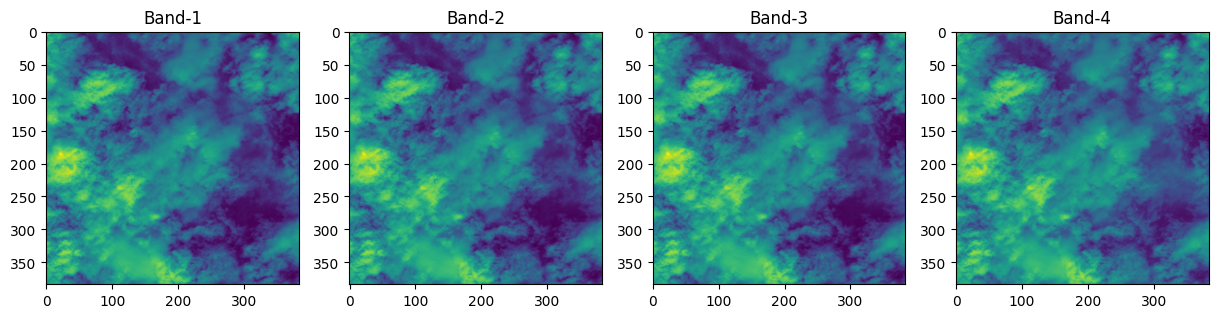

In [21]:
## Display various bands from an input image
input_data, label = full_data[9]
TorchAdapter.visualize_all_bands(input_data, 4, 1, 4)

## Display the Segmentation of the Above Image

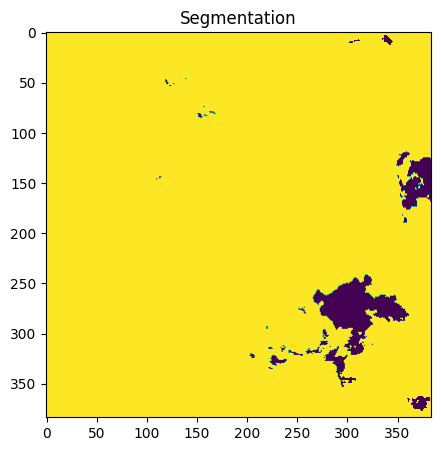

In [22]:
input_data, label = full_data[9]
TorchAdapter.visualize_all_bands(label, 1, 1, 1)

### Method to Return Model

In [ ]:
def get_model():
    ## Define Model
    model = FullyConvolutionalNetwork(4, 2)
    return model

### Train Model
Accuracy will not be high sinvce training is performed on a small dataset for only 5 epochs

In [ ]:
def train_one_epoch(model, train_loader, optimizer, loss_fn, device):
    model.train()
    for i, sample in enumerate(train_loader):
        inputs, labels = sample
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(True):
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()
    return loss.item()

In [ ]:
def train_model(model, loader, device):
    ## Define hyper-parameters
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for e in range(epoch_nums):
        epoch_loss = train_one_epoch(model, loader, optimizer, loss_fn, device)
        print('Epoch [{}/{}], Training Loss: {:.4f}'.format(e + 1, epoch_nums, epoch_loss))

In [ ]:
def train_distributed(use_gpu):
    backend = "nccl" if use_gpu else "gloo"
    dist.init_process_group(backend)
    device = int(os.environ["LOCAL_RANK"]) if use_gpu  else "cpu"
    model = get_model().to(device)
    model_ddp = DDP(model)
    sampler = DistributedSampler(full_data)
    loader = DataLoader(full_data, batch_size=batch_size, sampler=sampler)

    train_model(model_ddp, loader, device)

## Start Distributed Training

In [ ]:
print("Starting training")
distributor = TorchDistributor(num_processes=2, local_mode=True, use_gpu=False)
distributor.run(train_distributed, False)